In [1]:
import midynet
import midynet.util.display as display
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
import pathlib

display.setup_dir("./")

plot = midynet.metrics.Statistics.plot

paths_to_figures = [".", "../../../../papers/p-midynet/paper1-mutual_info/figures"]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))
path_to_data = pathlib.Path("../../../../data/midynet-data/figure3")

## Loading the experiments

In [2]:
dynamics = "ising"
small_exp = {}
small_xaxis = {}
for m in ["exact", "annealed", "full-meanfield", "meanfield"]:
    small_exp[m] = midynet.experiments.Experiment.load_from_file(
        path_to_data / f"figure3-small-{dynamics}.{m}/config.pickle"
    )
    small_xaxis[m] = small_exp[m].config.dynamics.get_coupling()

    
large_exp = {}
large_xaxis = {}
for m in ["annealed", "meanfield"]:
    large_exp[m] = midynet.experiments.Experiment.load_from_file(
        path_to_data / f"figure3-large-T1000-{dynamics}.{m}/config.pickle"
    )
    large_xaxis[m] = large_exp[m].config.dynamics.get_coupling()
    
if dynamics == "sis":
    xlabel = r"Infection probability $[\alpha]$"
    xmin, xmax = 0, 1
elif dynamics == "cowan":
    xlabel = r"Activity gain $[\nu\langle k \rangle]$"
    xmin, xmax = 0, 4
elif dynamics == "ising":
    xlabel = r"Coupling $[J\langle k \rangle]$"
    xmin, xmax = 0, 4

    

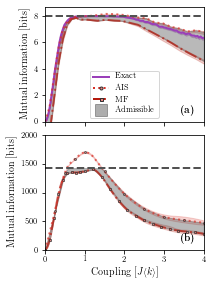

In [14]:
SCALE = 1

fig, ax = plt.subplots(2, 1, figsize=(SCALE * 3, SCALE* 4), sharex=True)
# t_index = np.where(np.array(T) == 100)[0][0]
# ec_index = np.where(np.array(E) == 5)[0][0]
# ec = E[ec_index]
# t = T[t_index]
color = {
    "exact":display.dark_colors["purple"],
    "mf":display.dark_colors["red"],
    "ais":display.med_colors["red"],
    "lines":display.dark_colors["grey"],
    
}

linestyle = {
    "exact": "solid",
    "ais": "dotted",
    "mf": "dashdot",
}

marker = {
    "exact": "None",
    "ais": "o",
    "mf": "s",
}

mi = {} 
hg = {}
for key, exp in small_exp.items():
    mi[key] = midynet.metrics.Statistics({
        k: exp.metrics["mutualinfo"].data[exp.name][f"mi-{k}"] 
        for k in ["mid", "high", "low"]
    })
    hg[key] = midynet.metrics.Statistics({
        k: exp.metrics["mutualinfo"].data[exp.name][f"hg-{k}"] 
        for k in ["mid", "high", "low"]
    })

plot(ax[0], small_xaxis["exact"], mi["exact"], 
    fill_alpha=0.3, 
    color=color["exact"],
    fill=True,
    bar=False,
    linestyle=linestyle["exact"],
    linewidth=SCALE * 2,
    marker=marker["exact"],
)

plot(ax[0], small_xaxis["meanfield"], mi["meanfield"], 
    fill_alpha=0.3, 
    alpha=0.7, 
    color=color["mf"],
    markeredgecolor=color["lines"], 
    markerfacecolor=display.light_colors["red"],
    interpolate="linear",
    fill_color=color["mf"], 
    fill=True,
    bar=False,
    linestyle=linestyle["mf"],
    linewidth=SCALE * 2,
    marker=marker["exact"],
    markersize=SCALE * 2,
    spacing=1,
)

plot(ax[0], small_xaxis["annealed"], mi["annealed"], 
    fill_alpha=0.3, 
    alpha=0.7, 
    color=color["ais"],
    markeredgecolor=color["lines"], 
     markerfacecolor=display.light_colors["red"],
    interpolate="linear",
    fill=True,
    bar=False,
    linestyle=linestyle["ais"],
    linewidth=SCALE * 2,
    marker=marker["exact"],
    markersize=SCALE * 2,
    spacing=1,
)

y1 = np.clip(mi["meanfield"]["mid"], -10, hg["meanfield"]["mid"])
y2 = np.clip(mi["annealed"]["mid"], -10, hg["annealed"]["mid"])
ax[0].fill_between(small_xaxis["meanfield"], y1, y2, color=display.med_colors["grey"], alpha=0.4)
ax[0].plot(small_xaxis["meanfield"], hg["meanfield"]["mid"], linestyle="--", marker="None", color=display.med_colors["grey"], linewidth=2)
ax[0].set_xlim([xmin, xmax])
ax[0].set_ylim([0, ax[0].get_ylim()[-1]])
# ax[0].set_xlabel(xlabel, fontsize=fs["large"])
ax[0].set_ylabel("Mutual information [bits]", fontsize=SCALE * display.fontsizes["large"])
ax[0].tick_params(axis='both', labelsize=SCALE * display.fontsizes["medium"])
display.Label.plot(ax[0], loc="bottom right", fontsize=SCALE * display.fontsizes["large"], box=False)

mi = {} 
hg = {}
for key, exp in large_exp.items():
    mi[key] = midynet.metrics.Statistics({
        k: exp.metrics["mutualinfo"].data[exp.name][f"mi-{k}"] 
        for k in ["mid", "high", "low"]
    })
    hg[key] = midynet.metrics.Statistics({
        k: exp.metrics["mutualinfo"].data[exp.name][f"hg-{k}"] 
        for k in ["mid", "high", "low"]
    })

plot(ax[1], large_xaxis["meanfield"], mi["meanfield"], 
    fill_alpha=0.3, 
    alpha=0.7, 
    color=color["mf"],
    markeredgecolor=color["lines"], 
    markerfacecolor=display.light_colors["red"],
    interpolate="quadratic",
    fill=True,
    bar=False,
    linestyle=linestyle["mf"],
    linewidth=SCALE * 2,
    marker=marker["mf"],
    markersize=SCALE * 2,
    spacing=1,
     error_scaling=0.5,
)

plot(ax[1], large_xaxis["annealed"], mi["annealed"], 
    fill_alpha=0.3, 
    alpha=0.7, 
    color=color["ais"],
    markeredgecolor=color["lines"], 
    markerfacecolor=display.light_colors["red"],
    interpolate="quadratic",
    fill=True,
    bar=False,
    linestyle=linestyle["ais"],
    linewidth=SCALE * 2,
    marker=marker["ais"],
    markersize=SCALE * 2,
    spacing=1,
     error_scaling=0.5,
)

x = np.linspace(min(large_xaxis["meanfield"]), max(large_xaxis["meanfield"]), 100)
ymf = interp1d(large_xaxis["meanfield"], mi["meanfield"]["mid"])
yann = interp1d(large_xaxis["annealed"], mi["annealed"]["mid"])
y1 = np.clip(ymf(x), -10, hg["meanfield"]["mid"][0])
y2 = np.clip(yann(x), -10, hg["annealed"]["mid"][0])
ax[1].fill_between(x, y1, y2, color=display.med_colors["grey"], alpha=0.4)
ax[1].plot(large_xaxis["meanfield"], hg["meanfield"]["mid"], linestyle="--", marker="None", color=display.med_colors["grey"], linewidth=2)
ax[1].set_xlim([xmin, xmax])
ax[1].set_ylim([0, 2000])
ax[1].set_xlabel(xlabel, fontsize=SCALE * display.fontsizes["large"])
ax[1].set_ylabel("Mutual information [bits]", fontsize=SCALE * display.fontsizes["large"])
ax[1].tick_params(axis='both', labelsize=SCALE * display.fontsizes["medium"])
display.Label.plot(ax[1], loc="bottom right", fontsize=SCALE * display.fontsizes["large"], box=False)
display.Label.clear()


handles = [
    Line2D(
        [0], [0], 
        color=color["exact"], 
        linestyle=linestyle["exact"], 
        marker=marker["exact"], 
        linewidth=2*SCALE, 
        label=r"Exact"),
    Line2D(
        [0], [0], 
        color=color["ais"], 
        markeredgecolor=color["lines"], 
        markerfacecolor=display.light_colors["red"],
        linestyle=linestyle["ais"], 
        marker=marker["ais"], 
        linewidth=2*SCALE, 
        markersize=3*SCALE, 
        
        label=r"AIS"),
    Line2D(
        [0], [0], 
        color=color["mf"], 
        markeredgecolor=color["lines"], 
        markerfacecolor=display.light_colors["red"],
        linestyle=linestyle["mf"], 
        marker=marker["mf"], 
        linewidth=2*SCALE, 
        markersize=3*SCALE, 
        label=r"MF"),
    Line2D(
        [0], [0], 
        color=display.dark_colors["grey"], 
        alpha=0.4, 
        linestyle="None", 
        marker="s",
        markersize=12, 
        label=r"Admissible"),
]
ax[0].legend(handles=handles, fontsize=SCALE * display.fontsizes["medium"], loc="lower center")

fig.tight_layout()
plt.subplots_adjust(hspace=0.12)

if SCALE==1:
    for p in paths_to_figures:
        fig.savefig(p / "svg/p1-figure3.svg")
        fig.savefig(p / "png/p1-figure3.png")
        fig.savefig(p / "pdf/p1-figure3.pdf")